## Nonlinear Schrödinger Equation

The nonlinear Schrödinger equation with periodic boundary conditions is given by:

$$
i h_t + 0.5 h_{xx} + |h|^2 h = 0, \quad x \in [-5, 5], \quad t \in [0, \pi/2].
$$

### Initial and Boundary Conditions

- **Initial Condition**:
  $$
  h(0, x) = 2 \, \text{sech}(x).
  $$

- **Periodic Boundary Conditions**:
  $$
  h(t, -5) = h(t, 5), \quad h_x(t, -5) = h_x(t, 5).
  $$


## Loss Function

The total loss is defined as:

$$
MSE = MSE_0 + MSE_b + MSE_f,
$$

where:

- **Initial Data Loss**:
  $$
  MSE_0 = \frac{1}{N_0} \sum_{i=1}^{N_0} \left| h(0, x_i^0) - h_i^0 \right|^2,
  $$

- **Boundary Condition Loss**:
  $$
  MSE_b = \frac{1}{N_b} \sum_{i=1}^{N_b} \left( \left| h(t_b^i, -5) - h(t_b^i, 5) \right|^2 + \left| h_x(t_b^i, -5) - h_x(t_b^i, 5) \right|^2 \right),
  $$

- **PDE Residual Loss**:
  $$
  MSE_f = \frac{1}{N_f} \sum_{i=1}^{N_f} \left| f(t_f^i, x_f^i) \right|^2,
  $$

with:
$$
f(t, x) = i h_t + 0.5 h_{xx} + |h|^2 h.
$$


In [34]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

import torch
import torch.nn as nn
import torch.optim as optim
from scipy.integrate import solve_ivp
from torch.optim.lr_scheduler import StepLR
from scipy.fftpack import fft, ifft
import lhsmdu
from pyDOE import lhs
from scipy.interpolate import interp1d
from torch.optim.lr_scheduler import LambdaLR

In [35]:
device = torch.device('cuda:0')

In [36]:
def derivative(y, t) :
    return torch.autograd.grad(
        y, t, create_graph=True,\
                               grad_outputs=torch.ones(y.size()).to(device))[0]

In [37]:
# Number of samples
Nt = 50
Nx = 50
N_total = 20000

lhs_samples = lhs(2, samples= N_total)        # 2차원 샘플링 (시간, 공간)
t_samples = lhs_samples[:, 0] * (np.pi/2)
x_samples = lhs_samples[:, 1] * 10 - 5          # [-5, 5] 범위
tx_grid = torch.tensor(np.column_stack([t_samples, x_samples]), dtype=torch.float32).to(device).requires_grad_(True) 

lhs_init = lhs(1, samples=50)
tx_init = torch.tensor(np.column_stack([np.zeros(50), lhs_init[:, 0] * 10 - 5]), dtype=torch.float32).to(device).requires_grad_(True)

lhs_bdry = lhs(1, samples=50)
lhs_b_right = torch.tensor(np.column_stack([lhs_bdry[:, 0] * (np.pi/2), np.full(50, 5)]), dtype=torch.float32).to(device).requires_grad_(True)
lhs_b_left = torch.tensor(np.column_stack([lhs_bdry[:, 0] * (np.pi/2), np.full(50, -5)]), dtype=torch.float32).to(device).requires_grad_(True)

h_init = 2 / torch.cosh(tx_init[:, 1:2]).view(-1,1)        # h(0,x) = sech(x)

In [38]:
class model(nn.Module):
    def __init__(self, hidden_dims):
        super(model, self).__init__()

        self.layers = nn.ModuleList()
        for i in range(len(hidden_dims) - 1):
            self.layers.append(nn.Linear(hidden_dims[i], hidden_dims[i + 1]))

        for layer in self.layers:
            nn.init.xavier_uniform_(layer.weight)

        self.act = nn.Tanh()

    def forward(self, x):
        for layer in self.layers[:-1]:
            x = self.act(layer(x))
        x = self.layers[-1](x)
        u, v = x[:, 0].view(-1,1), x[:, 1].view(-1,1)  # 실수부와 허수부 분리
        return u, v

In [39]:
network = model(hidden_dims=[2,100,100,100,100,100,2]).to(device)
loss_f = nn.MSELoss()

#optimizer = optim.Adam(network.parameters(),lr = 1e-3)  이거는 한번 미분
optimizer = torch.optim.LBFGS(          # 이거는 두 번 미분
    network.parameters(),
    lr=1,
    max_iter=100,
    tolerance_grad=1e-10,
    tolerance_change=1e-9,
    history_size=10
)
lambda_lr = lambda epoch: 0.95 ** epoch  # 매 epoch마다 학습률을 0.95배로 감소

scheduler = LambdaLR(optimizer, lr_lambda=lambda_lr)
EPOCHS = 2000

## Train

In [40]:
# Train
loss_list =[]
loss_list_ge = []
loss_list_init = []
loss_list_bdry = []

network.train()

#===========================================================================
for epoch in range(1, EPOCHS + 1):
    def closure():
        optimizer.zero_grad()  # 그래디언트 초기화

        # Forward Pass
        output_u, output_v = network(tx_grid)       # 전체 범위에서 예측
        output_i_u , output_i_v = network(tx_init)              # 초기 조건 예측
        output_b_left_u , output_b_left_v = network(lhs_b_left)  # 경계 조건 (왼쪽)
        output_b_right_u , output_b_right_v = network(lhs_b_right)  # 경계 조건 (오른쪽)

        # 1차 도함수 계산
        grad_output_u = derivative(output_u, tx_grid)
        grad_output_v = derivative(output_v, tx_grid)
        u_t = grad_output_u[:, 0].view(-1, 1)
        v_t = grad_output_v[:, 0].view(-1, 1)

        # 2차 도함수 계산
        u_xx = derivative(grad_output_u[:, 1], tx_grid)[:, 1].view(-1, 1)
        v_xx = derivative(grad_output_v[:, 1], tx_grid)[:, 1].view(-1, 1)

        # 초기 조건 손실
        loss_init = loss_f(output_i_u, h_init) + loss_f(output_i_v, torch.zeros_like(h_init))

        # 경계 조건 손실
        loss_h_bdry = loss_f(output_b_left_u - output_b_right_u, torch.zeros_like(output_b_left_u)) + \
                      loss_f(output_b_left_v - output_b_right_v, torch.zeros_like(output_b_left_v))
        
        grad_b_left_u = derivative(output_b_left_u, lhs_b_left)[:, 1].view(-1, 1)
        grad_b_right_u = derivative(output_b_right_u, lhs_b_right)[:, 1].view(-1, 1)
        grad_b_left_v = derivative(output_b_left_v, lhs_b_left)[:, 1].view(-1, 1)
        grad_b_right_v = derivative(output_b_right_v, lhs_b_right)[:, 1].view(-1, 1)
        
        loss_h_x_bdry = loss_f((grad_b_left_u - grad_b_right_u), torch.zeros_like(grad_b_left_u)) + \
                        loss_f((grad_b_left_v + grad_b_right_v), torch.zeros_like(grad_b_left_v))
        loss_bdry = loss_h_bdry + loss_h_x_bdry

        # PDE residual loss
        residual_real = -v_t + 0.5 * u_xx + output_u * (output_u**2 + output_v**2)
        residual_imag = u_t + 0.5 * v_xx + output_v * (output_u**2 + output_v**2)
        loss_ge = loss_f(residual_real, torch.zeros_like(output_u)) + \
                  loss_f(residual_imag, torch.zeros_like(output_u))

        loss = loss_ge + loss_init + loss_bdry
        loss.backward(retain_graph=True)

        loss_list.append(loss.item())

        return loss

    optimizer.step(closure)
    #scheduler.step()
    

    if epoch % 10 == 0:
        print(f'EPOCH: {epoch}, Loss: {loss_list[-1]:.6f}')

print("Training Finished.")

EPOCH: 10, Loss: 0.021596
EPOCH: 20, Loss: 0.006375
EPOCH: 30, Loss: 0.001828
EPOCH: 40, Loss: 0.000864
EPOCH: 50, Loss: 0.000431
EPOCH: 60, Loss: 0.000262
EPOCH: 70, Loss: 0.000174
EPOCH: 80, Loss: 0.000123
EPOCH: 90, Loss: 0.000076
EPOCH: 100, Loss: 0.000067
EPOCH: 110, Loss: 0.000059
EPOCH: 120, Loss: 0.000045
EPOCH: 130, Loss: 0.000041
EPOCH: 140, Loss: 0.000041
EPOCH: 150, Loss: 0.000041
EPOCH: 160, Loss: 0.000041
EPOCH: 170, Loss: 0.000041
EPOCH: 180, Loss: 0.000041
EPOCH: 190, Loss: 0.000041
EPOCH: 200, Loss: 0.000041
EPOCH: 210, Loss: 0.000041
EPOCH: 220, Loss: 0.000041
EPOCH: 230, Loss: 0.000041
EPOCH: 240, Loss: 0.000041
EPOCH: 250, Loss: 0.000041
EPOCH: 260, Loss: 0.000041
EPOCH: 270, Loss: 0.000041
EPOCH: 280, Loss: 0.000041
EPOCH: 290, Loss: 0.000041
EPOCH: 300, Loss: 0.000041
EPOCH: 310, Loss: 0.000041
EPOCH: 320, Loss: 0.000041
EPOCH: 330, Loss: 0.000041
EPOCH: 340, Loss: 0.000041
EPOCH: 350, Loss: 0.000041
EPOCH: 360, Loss: 0.000041
EPOCH: 370, Loss: 0.000041
EPOCH: 380

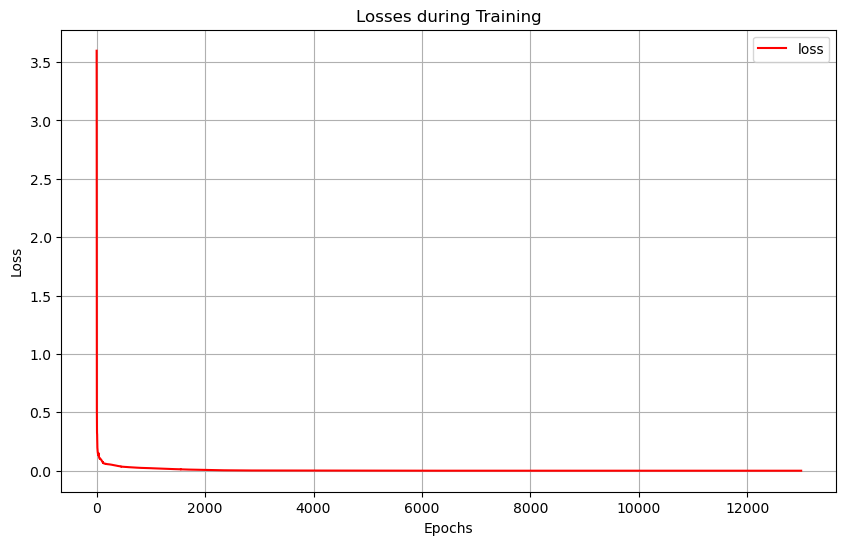

In [41]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(loss_list) + 1), loss_list, label='loss', color='r')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Losses during Training')
plt.legend()
plt.grid(True)
plt.show()

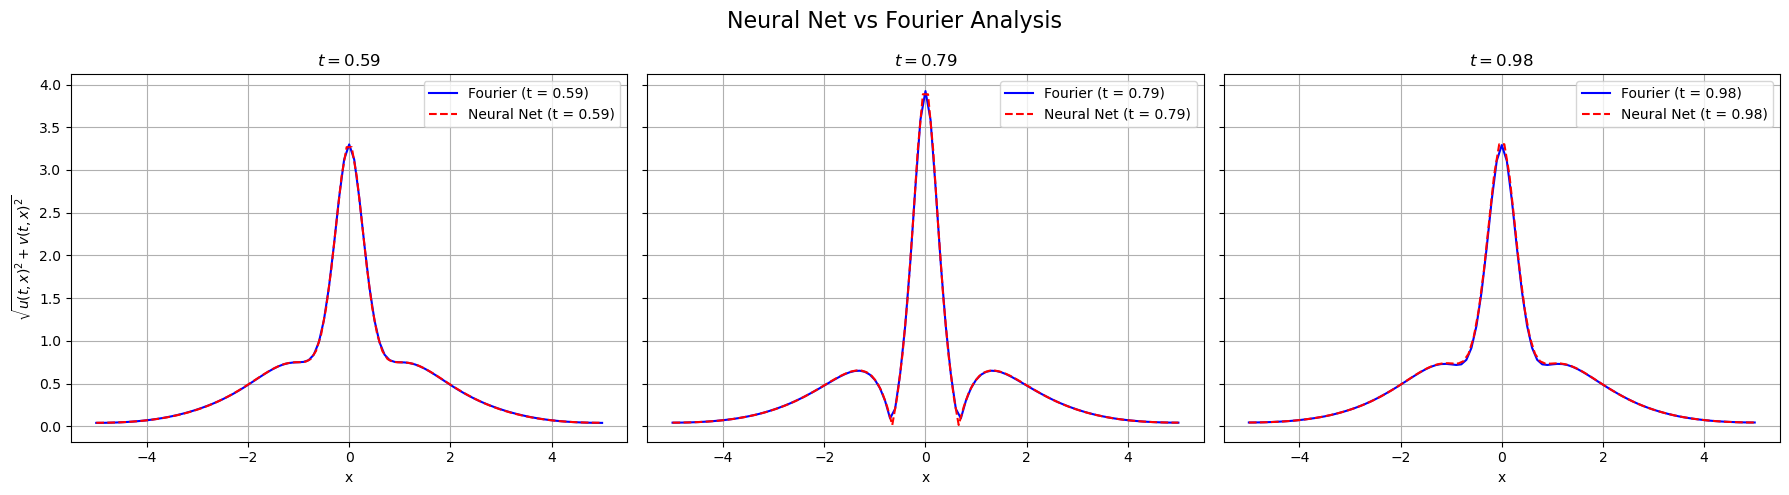

In [42]:
t_values = torch.tensor([0.59, 0.79, 0.98], device=device).view(-1, 1)
x_values = torch.linspace(-5, 5, 100, device=device).view(-1, 1)

# 신경망 입력 데이터 (tx_grid 생성)
tx_grid = torch.cat(
    [t_values.repeat_interleave(len(x_values), dim=0),  # 시간 반복
     x_values.repeat(len(t_values), 1)],  # 공간 반복
    dim=1
)

# 신경망 예측
network.eval()
with torch.no_grad():
    output = network(tx_grid)
    u,v = output
    u = u.view(len(t_values), -1)
    v = v.view(len(t_values), -1)

# |h(t, x)| 계산
combined = torch.sqrt(u**2 + v**2).cpu().numpy()


sigma = 1
dt = 0.001
t = np.linspace(0, 1.5, 1501)  # 시간 범위
num_steps = len(t)

dx = 0.1
x = np.linspace(-5, 5, 101)  # 공간 범위
psi = 2 / np.cosh(x)  # 초기 조건

T, X = np.meshgrid(t, x)
Z = np.zeros((len(x), num_steps), dtype=np.complex128)

N = len(psi)
w = np.fft.fftfreq(N, d=dx) * 2 * np.pi
L = -0.5j * (w**2)  # 푸리에 공간 선형항 계산

for step in range(num_steps):
    Z[:, step] = psi  # 해당 t에서 psi(x,t) 저장

    psi_hat = fft(psi)
    psi_hat = psi_hat * np.exp(L * dt)  # 선형항 연산
    psi = ifft(psi_hat)  # 역푸리에 반환

    def f(psi):  # Runge-Kutta 비선형항
        return 1j * sigma * np.abs(psi) ** 2 * psi

    k1 = f(Z[:, step])
    k2 = f(Z[:, step] + dt * k1 / 2)
    k3 = f(Z[:, step] + dt * k2 / 2)
    k4 = f(Z[:, step] + dt * k3)

    psi = psi + (dt / 6) * (k1 + 2 * k2 + 2 * k3 + k4)

fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for i, (ax, t_nn) in enumerate(zip(axs, t_values.flatten().cpu().numpy())):
    

    nearest_idx = np.argmin(np.abs(t - t_nn))
    ax.plot(x, np.abs(Z[:, nearest_idx]), label=f"Fourier (t = {t_nn:.2f})", color='b', linestyle='-')

    ax.plot(x_values.cpu().numpy(), combined[i], label=f"Neural Net (t = {t_nn:.2f})", color='r', linestyle='--')
    ax.set_title(f"$t = {t_nn:.2f}$")
    ax.set_xlabel("x")
    ax.grid()
    ax.legend()

axs[0].set_ylabel(r"$\sqrt{u(t, x)^2 + v(t, x)^2}$")
fig.suptitle(r"Neural Net vs Fourier Analysis", fontsize=16)
plt.tight_layout()
plt.show()

In [43]:
relative_errors = []

x_values_resampled = x_values.cpu().numpy().flatten()
for i, t_nn in enumerate(t_values.flatten().cpu().numpy()):

    nearest_idx = np.argmin(np.abs(t - t_nn))
    fourier_result = np.abs(Z[:, nearest_idx])

    interpolation = interp1d(x, fourier_result, kind='cubic', fill_value="extrapolate")
    fourier_resampled = interpolation(x_values_resampled)

    neural_net_result = combined[i]  # Nn 결과

    l2_norm_error = np.linalg.norm(fourier_resampled - neural_net_result) / np.linalg.norm(fourier_resampled)
    relative_errors.append(l2_norm_error)

for i, (t_nn, error) in enumerate(zip(t_values.flatten().cpu().numpy(), relative_errors)):
    print(f"t = {t_nn:.2f}, Relative L2 Norm Error: {error:.6f}")

average_error = np.mean(relative_errors)
print(f"Average Relative L2 Norm Error: {average_error:.6f}")


t = 0.59, Relative L2 Norm Error: 0.004505
t = 0.79, Relative L2 Norm Error: 0.017225
t = 0.98, Relative L2 Norm Error: 0.016845
Average Relative L2 Norm Error: 0.012858


중간 시간대에서 grid를 많이 뽑으면 좋은 결과를 만들어낼 수 있음